In [1]:
import os
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".9"

import subprocess
import tempfile
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from copy import deepcopy
from jax import jit, vmap, value_and_grad
from jax.tree_util import tree_map, Partial
from jaxley.optimize.transforms import ParamTransform, Transform
from jax import Array
from jax.typing import ArrayLike
import jax
import jaxlib
import jaxley as jx
import jax.numpy as jnp
from jax.scipy.integrate import trapezoid
from jaxley.channels import Leak
import jaxley.optimize.transforms as jt
from jaxley.solver_gate import save_exp
import pandas as pd
import optax
from itertools import chain
import json
from scipy import interpolate
import pickle
import random
from functools import partial

from scipy.signal import medfilt, find_peaks
from scipy.ndimage import gaussian_filter1d
from typing import Any, Callable, NamedTuple, Tuple

from Allen_mech_allActive import * 

import time

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

from jaxley.optimize.utils import l2_norm

from train_utils import *
from train_func import batched_stepCurrent_training
from loss_funcs import *

## Load in Data

In [2]:
load_params = 1

# load in swc file from patch_seq morph

ID = 623434306
trans_file = str(ID) + '_transformed.swc'
base_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/623434306_data'
data_path = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/623434306_data'

swc_file = os.path.join(base_dir, trans_file)



metadata_file = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/20200711_patchseq_metadata_mouse.csv'
metadata = metadata = pd.read_csv(metadata_file)

metadata_cell = metadata[metadata['cell_specimen_id'] == ID]
ephys_ID = metadata_cell['ephys_session_id'].values[0]
metadata_cell.head()

output_dir = os.path.join('/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/623434306_data/raw_ephys', str(ID), 'ephys_ID_' + str(ephys_ID)+'.json')
processed_data_dir = os.path.join('/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/623434306_data/raw_ephys', str(ID))


In [3]:
data_files = find_files(str(ephys_ID), data_path)

if not os.path.exists(output_dir):
    call_load_data_in_allensdk(ID)
    
    command = [
    "conda", "run",
    "-n", "allensdk",
    "python", "-m", "ipfx.bin.run_pipeline_from_nwb_file",
    data_files[0],
    processed_data_dir
    ]

    try:
        result = subprocess.run(
            command,
            check=True,
            capture_output=True,
            text=True
        )
        print("Command output:", result.stdout)
    except subprocess.CalledProcessError as e:
        print("Command failed with error:", e.stderr)
    
with open(output_dir, 'r') as f:
    ephys_data = json.load(f)
    print('Data file loaded')

# get index of last slash in data_files[0]
slash_idx = data_files[0].rfind('/')
# get the file name
folder_name = data_files[0][slash_idx+1:-4]
processed_data_file = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/623434306_data/raw_ephys/623434306/sub-617297314_ses-623434287_icephys/output.json'#os.path.join(processed_data_dir, folder_name, 'output.json')
with open(processed_data_file, 'r') as f:
    sweep_data = json.load(f)
    print('Sweep file loaded')

sweep_features = sweep_data['sweep_extraction']['sweep_features']
sweep_ids = list(ephys_data['long_squares'].keys())

Data file loaded
Sweep file loaded


## Build Cell template

In [4]:
nseg_per_branch = 1
cell = jx.read_swc(swc_file, nseg_per_branch, max_branch_len=20000.0, assign_groups=True)

print(cell.shape)
print(list(cell.groups.keys()))
test = cell.nodes



/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/Miniforge/envs/jax_gpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


(277, 277)
['soma', 'axon', 'basal']


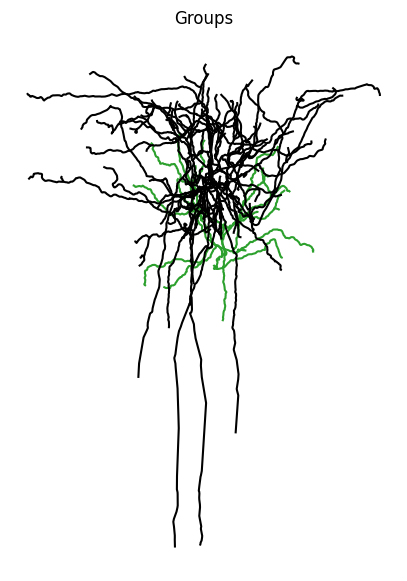

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7))
colors = plt.cm.tab10.colors
cell.basal.vis(ax=ax, col=colors[2])
cell.axon.vis(ax=ax, col='k')
cell.soma.vis(ax=ax, col=colors[0])
plt.axis("off")
plt.title("Groups")
plt.show()

In [6]:
# Get relevant ephys parameters from ephys data to set initial conditions

# resting potential
# resistance
# capacitance
# rheobase
# reversal potentials
# conductances if available

# decide on loss attributes
# Option 1. point-point comparison of voltage/calcium traces
# Option 2. Comparison of features extracted from traces & calculated from model (e.g. AP threshold, AP amplitude, AP width, frequency, etc.)
# ^ is what was done for original Allen biophysical model fitting, but optimization was done by hand


# All active Allen biophysical model:
# Axon was removed, replaced with AIS of 2 compartments (?) 30 um each, 60 um length total
# inhibitory neurons only had a single dendritic type, excitatory neurons had basal + apical

# optimized passive & active properties with the same procedure
# Passive properties: one value for each was uniformly distributed across all compartments
    # specific capacitance (cm): 'capacitance'
    # passive conductance (g_pas): Leak_gLeak
    # passive reversal potential (e_pas): Leak_eLeak
    # cytoplasmic resistivity (Ra): 'axial_resistivity'

# Active properties: uniformly distributed across all compartments for each group. Every group received a separate set of channels
# ion channel identities & mechanisms were identical to those in the Allen perisomatic models (inhib cells had something diff --> look at)
# slow inactivating K current was replaced with two separate K currents: one fast inactivating, one slow inactivating (Kv1 & Kv2). 
# Original M current was replaced by a model from rat CA1 neurons Im_v2
# total of 26 free parameters: 18 active conductance densities, 4 intracellular Ca2+ dynamics parameters, 4 passive parameters

# simulation temperatre was 34 degrees C, check if cell was recorded at same temp & if not scale kinetics with a Q10 of 2.3

### Test resampling

Text(0.5, 1.0, 'All sweeps')

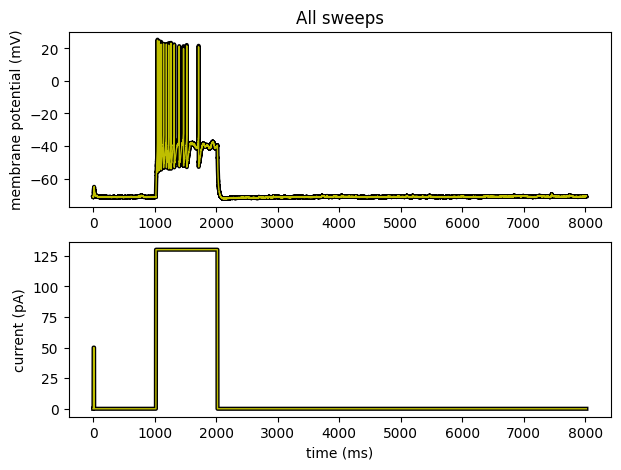

In [7]:
# _, new_voltage = resample_timeseries(ephys_data['long_squares']['20']['time'], ephys_data['long_squares']['20']['voltage'], new_dt=0.0001)
# new_time, new_current = resample_timeseries(ephys_data['long_squares']['20']['time'], ephys_data['long_squares']['20']['current'], new_dt=0.0001)
# stim_idx = find_deflection(new_current[new_time < 0.1])

sweep_id = sweep_ids[20]

# get target voltage & time
new_dt = 0.0001 # time step in seconds
_, new_voltage = resample_timeseries(ephys_data['long_squares'][sweep_id]['time'], ephys_data['long_squares'][sweep_id]['voltage'], new_dt=0.0001)
new_time, new_current = resample_timeseries(ephys_data['long_squares'][sweep_id]['time'], ephys_data['long_squares'][sweep_id]['current'], new_dt=0.0001)


sweep_features = sweep_data['sweep_extraction']['sweep_features']

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
axes[0].plot(np.array(ephys_data['long_squares'][sweep_id]['time']) * 1e3, ephys_data['long_squares'][sweep_id]['voltage'], color='k', linewidth=3)
axes[0].plot(new_time * 1e3, new_voltage, color='y', linewidth=1)
axes[1].plot(np.array(ephys_data['long_squares'][sweep_id]['time']) * 1e3, ephys_data['long_squares'][sweep_id]['current'], color='k', linewidth=3)
axes[1].plot(new_time * 1e3, new_current, color='y', linewidth=1)
axes[0].set_ylabel("membrane potential (mV)")
axes[1].set_ylabel("current (pA)")
axes[1].set_xlabel("time (ms)")
axes[0].set_title("All sweeps")
#axes[0].set_xlim(0, 100)
#axes[0].set_ylim(-80, -60)
#axes[1].set_xlim(0, 100)
#axes[1].set_ylim(-0.1, 75)

# minimal sampling rate that maintains spike fidelity is 0.0001s, or 0.1ms
# original sampling rate was 0.02ms, so resampled to 0.1ms

## Setup passive data

949
949


Text(0.5, 1.0, 'All sweeps')

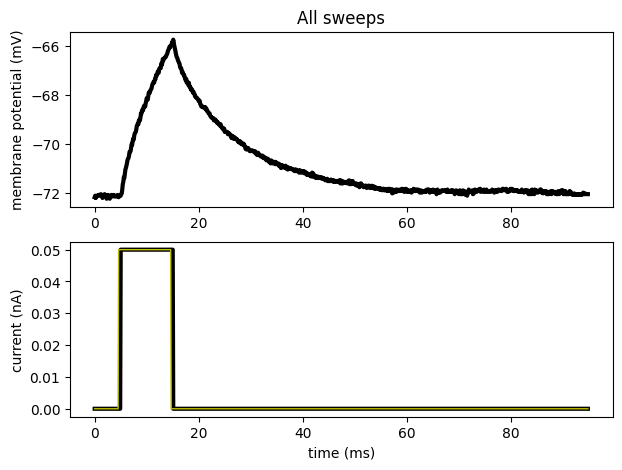

In [8]:
post_stim = 80
passive_transient_data = make_data_dict(sweep_ids, ephys_data, sweep_features, stim_time=[0,0.1], pre_stim=None, post_stim=post_stim)
window0 = tuple(np.logical_and(passive_transient_data[sweep_id]['target']['time'] >= 0, passive_transient_data[sweep_id]['target']['time'] <= passive_transient_data[sweep_id]['target']['time'][-1]))
window1 = tuple(np.logical_and(passive_transient_data[sweep_id]['target']['time'] >= 0, passive_transient_data[sweep_id]['target']['time'] <= passive_transient_data[sweep_id]['target']['time'][-1]))
transient_windows = tuple([window0, window1])
id = '29'
print(len(window0))
print(len(passive_transient_data[id]['target']['voltage']))

## Troubleshooting plot to check model stim corresponds to target timeseries correctly 
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
axes[0].plot(passive_transient_data[id]['target']['time']*1000, passive_transient_data[id]['target']['voltage'], color='k', linewidth=3)
axes[1].plot(passive_transient_data[id]['target']['time']*1000, passive_transient_data[id]['target']['current'] / 1e3, color='k', linewidth=3)
axes[1].plot(passive_transient_data[id]['target']['time']*1000, passive_transient_data[id]['input']['current'][2:], color='y', linewidth=1)
axes[0].set_ylabel("membrane potential (mV)")
axes[1].set_ylabel("current (nA)")
axes[1].set_xlabel("time (ms)")
axes[0].set_title("All sweeps")


1020
1020


Text(0.5, 1.0, 'All sweeps')

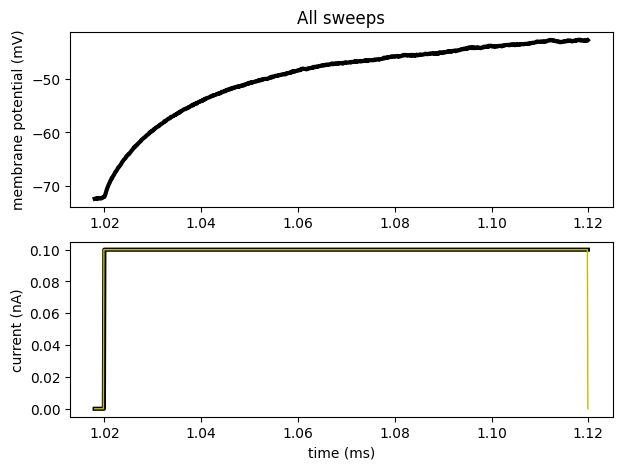

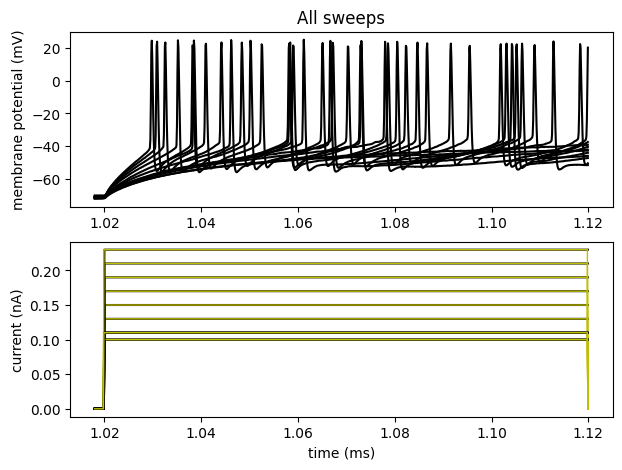

In [9]:
start_data = make_data_dict(sweep_ids, ephys_data, sweep_features, stim_dur = 100, stim_time=None, pre_stim=2, post_stim=-900)
active_start_data = start_data.copy()
for sweep_id in start_data.keys():
    if start_data[sweep_id]['input']['i_amp'] <= 0.1:
        active_start_data.pop(sweep_id)
        
window0 = tuple(np.logical_and(active_start_data[sweep_id]['target']['time'] >= 0, active_start_data[sweep_id]['target']['time'] <= active_start_data[sweep_id]['target']['time'][-1]))
window1 = tuple(np.logical_and(active_start_data[sweep_id]['target']['time'] >= 0, active_start_data[sweep_id]['target']['time'] <= active_start_data[sweep_id]['target']['time'][-1]))
transient_windows = tuple([window0, window1])
id = '29'
print(len(window0))
print(len(active_start_data[id]['target']['voltage']))

## Troubleshooting plot to check model stim corresponds to target timeseries correctly 
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
axes[0].plot(active_start_data[id]['target']['time'], active_start_data[id]['target']['voltage'], color='k', linewidth=3)
axes[1].plot(active_start_data[id]['target']['time'], active_start_data[id]['target']['current'] / 1e3, color='k', linewidth=3)
axes[1].plot(active_start_data[id]['target']['time'], active_start_data[id]['input']['current'][1:], color='y', linewidth=1)
axes[0].set_ylabel("membrane potential (mV)")
axes[1].set_ylabel("current (nA)")
axes[1].set_xlabel("time (ms)")
axes[0].set_title("All sweeps")

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in active_start_data.keys():
    axes[0].plot(active_start_data[sweep_id]['target']['time'], active_start_data[sweep_id]['target']['voltage'], color='k')
    axes[1].plot(active_start_data[sweep_id]['target']['time'], active_start_data[sweep_id]['target']['current'] / 1e3, color='k')
    axes[1].plot(active_start_data[sweep_id]['target']['time'], active_start_data[sweep_id]['input']['current'][1:], color='y', linewidth=1)
axes[0].set_ylabel("membrane potential (mV)")
axes[1].set_ylabel("current (nA)")
axes[1].set_xlabel("time (ms)")
axes[0].set_title("All sweeps")



In [10]:
for sweep_id in active_start_data.keys():
    print(active_start_data[sweep_id]['input']['i_amp'])

0.11000000000000003
0.13000000000000003
0.15000000000000002
0.17000000000000007
0.19000000000000006
0.21000000000000008
0.23000000000000007
0.10000000000000003
0.10000000000000003
0.11000000000000003
0.11000000000000003


In [11]:
all_data = make_data_dict(sweep_ids, ephys_data, sweep_features, stim_time=None, pre_stim=250, 
               post_stim=250, dt = 0.1, new_dt=0.0001)

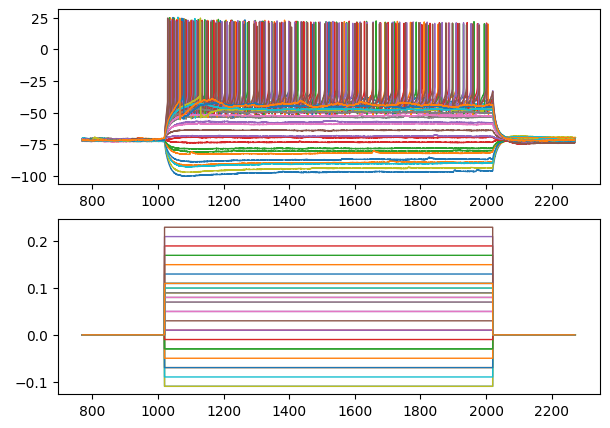

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in all_data.keys():
    axes[0].plot(all_data[sweep_id]['target']['time']*1000, all_data[sweep_id]['target']['voltage'],linewidth=1)
    axes[1].plot(all_data[sweep_id]['target']['time']*1000, all_data[sweep_id]['target']['current'] / 1e3,linewidth=1)

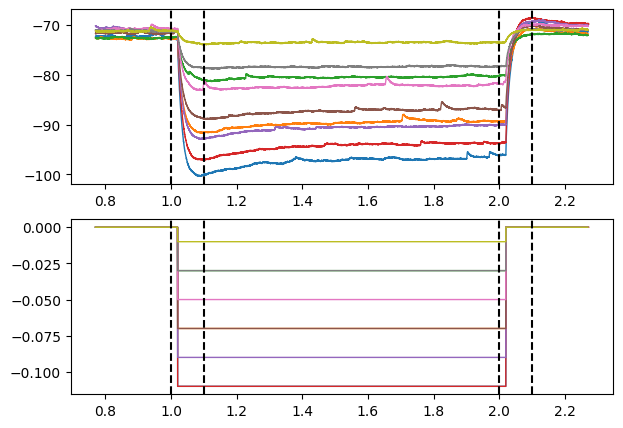

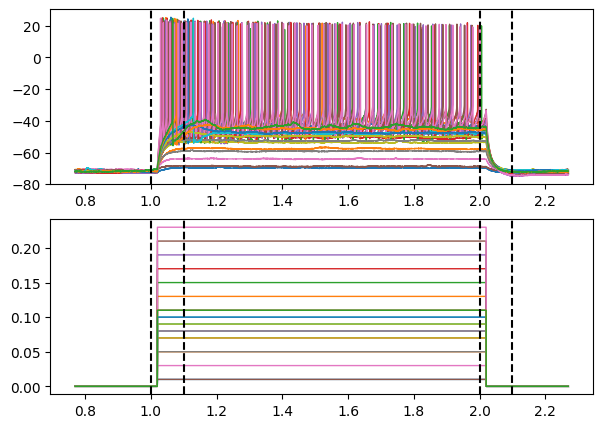

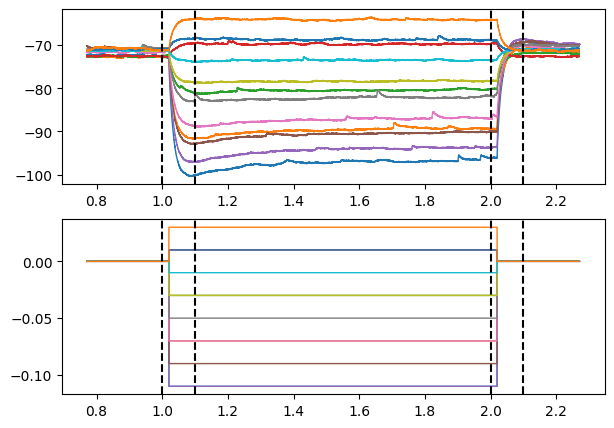

In [13]:
window0 = np.logical_and(all_data[sweep_id]['target']['time'] >= 1, all_data[sweep_id]['target']['time'] <= 1.1)
window1 = np.logical_and(all_data[sweep_id]['target']['time'] >= 2, all_data[sweep_id]['target']['time'] <= 2.1)
subthresh_windows = tuple([tuple(window0), tuple(window1)])

# Iterate through all_data and keep only the sweeps with a negative current amplitude
negative_data = all_data.copy()
for sweep_id in all_data.keys():
    if all_data[sweep_id]['input']['i_amp'] > 0:
        negative_data.pop(sweep_id)
        
positive_data = all_data.copy()
for sweep_id in all_data.keys():
    if all_data[sweep_id]['input']['i_amp'] < 0:
        positive_data.pop(sweep_id)
        
extra_positive_data = all_data.copy()
for sweep_id in all_data.keys():
    if all_data[sweep_id]['input']['i_amp'] < 0.1:
        extra_positive_data.pop(sweep_id)
        
subthresh_data = all_data.copy()
for sweep_id in all_data.keys():
    if all_data[sweep_id]['input']['i_amp'] > 0.05:
        subthresh_data.pop(sweep_id)
        
# plot to check that negative current sweeps are correct
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in negative_data.keys():
    axes[0].plot(negative_data[sweep_id]['target']['time'], negative_data[sweep_id]['target']['voltage'],linewidth=1)
    axes[1].plot(negative_data[sweep_id]['target']['time'], negative_data[sweep_id]['target']['current'] / 1e3,linewidth=1)
# plot vertical lines to show where the stimulus starts and ends
for ax in axes:
    ax.axvline(negative_data[sweep_id]['target']['time'][window0][0], color='k', linestyle='--')
    ax.axvline(negative_data[sweep_id]['target']['time'][window0][-1], color='k', linestyle='--')
    ax.axvline(negative_data[sweep_id]['target']['time'][window1][0], color='k', linestyle='--')
    ax.axvline(negative_data[sweep_id]['target']['time'][window1][-1], color='k', linestyle='--')
    
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in positive_data.keys():
    axes[0].plot(positive_data[sweep_id]['target']['time'], positive_data[sweep_id]['target']['voltage'],linewidth=1)
    axes[1].plot(positive_data[sweep_id]['target']['time'], positive_data[sweep_id]['target']['current'] / 1e3,linewidth=1)
for ax in axes:
    ax.axvline(positive_data[sweep_id]['target']['time'][window0][0], color='k', linestyle='--')
    ax.axvline(positive_data[sweep_id]['target']['time'][window0][-1], color='k', linestyle='--')
    ax.axvline(positive_data[sweep_id]['target']['time'][window1][0], color='k', linestyle='--')
    ax.axvline(positive_data[sweep_id]['target']['time'][window1][-1], color='k', linestyle='--')
    
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in subthresh_data.keys():
    axes[0].plot(subthresh_data[sweep_id]['target']['time'], subthresh_data[sweep_id]['target']['voltage'],linewidth=1)
    axes[1].plot(subthresh_data[sweep_id]['target']['time'], subthresh_data[sweep_id]['target']['current'] / 1e3,linewidth=1)
for ax in axes:
    ax.axvline(subthresh_data[sweep_id]['target']['time'][window0][0], color='k', linestyle='--')
    ax.axvline(subthresh_data[sweep_id]['target']['time'][window0][-1], color='k', linestyle='--')
    ax.axvline(subthresh_data[sweep_id]['target']['time'][window1][0], color='k', linestyle='--')
    ax.axvline(subthresh_data[sweep_id]['target']['time'][window1][-1], color='k', linestyle='--')
    


## Fit subthresh current pulse to find passive properties

In [14]:
# build pass_cell with only passive properties
nseg_per_branch = 1
pass_cell = jx.read_swc(swc_file, nseg_per_branch, max_branch_len=20000.0, assign_groups=True)

# Set free parameter bounds, for first run, copy distributions from Allen biophysical all-active model fitting

pass_bounds = [
    {'capacitance': custom_SigmoidTransform(0.5, 10)},
    {'capacitance': custom_SigmoidTransform(0.5, 10)},
    {'capacitance': custom_SigmoidTransform(0.5, 10)},
    {'axial_resistivity': custom_SigmoidTransform(50, 200)},
    {'Leak_gLeak': custom_SigmoidTransform(1e-7, 1e-2)},
    {'Leak_gLeak': custom_SigmoidTransform(1e-7, 1e-2)},
    {'Leak_gLeak': custom_SigmoidTransform(1e-7, 1e-2)},
]

pass_cell.set("v", -72) # initial voltage

pass_bound_names = [
                    'soma_capacitance', 
                    'basal_capacitance', 
                    'axon_capacitance', 
                    'axial_resistivity',
                    'soma_gLeak',
                    'basal_gLeak',
                    'axon_gLeak']

##########PASSIVE###############

# Capacitance (cm)

pass_cell.soma.set('capacitance', 1) #uF/cm^2
pass_cell.soma.make_trainable('capacitance')
pass_cell.basal.set('capacitance', 1)
pass_cell.basal.make_trainable('capacitance')
pass_cell.axon.set('capacitance', 1)
pass_cell.axon.make_trainable('capacitance')

# Axial resistance (Ra)
pass_cell.set('axial_resistivity', 125) # ohm cm
pass_cell.make_trainable('axial_resistivity')

# Leak
pass_cell.soma.insert(Leak())
pass_cell.basal.insert(Leak())
pass_cell.axon.insert(Leak())

pass_cell.set('Leak_gLeak', 0.0005)
pass_cell.soma.make_trainable('Leak_gLeak')
pass_cell.basal.make_trainable('Leak_gLeak')
pass_cell.axon.make_trainable('Leak_gLeak')
  

/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/Miniforge/envs/jax_gpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
Number of newly added trainable parameters: 1. Total number of trainable parameters: 7


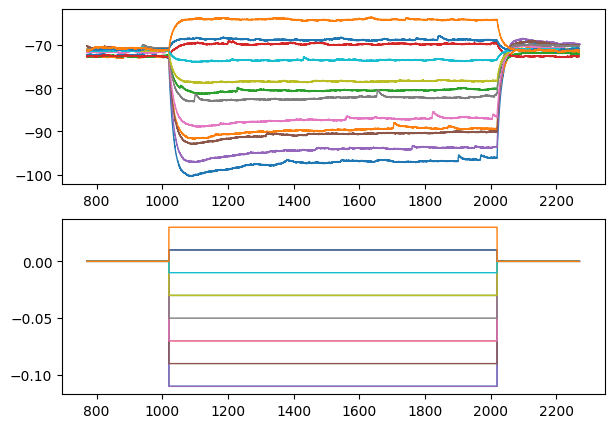

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in subthresh_data.keys():
    axes[0].plot(subthresh_data[sweep_id]['target']['time']*1000, subthresh_data[sweep_id]['target']['voltage'],linewidth=1)
    axes[1].plot(subthresh_data[sweep_id]['target']['time']*1000, subthresh_data[sweep_id]['target']['current'] / 1e3,linewidth=1)

In [16]:
# # get stim info to fit passive properties

# stim_idx = find_deflection(new_current[new_time < 0.1])

# stim_amp = max(new_current[new_time < 0.1]) / 1e3 # convert from pA to nA
# stim_dur = (stim_idx[1] - stim_idx[0]) * 0.0001 / 0.001 # convert from steps to seconds to ms
# stim_start = stim_idx[0] * 0.0001 / 0.001 # convert from steps to seconds to ms

# # Define stimulus parameters
# window_start = stim_start  # ms pre stim onset
# window_end = post_stim  # ms post stim offset
# i_delay = window_start  # stim starts at 1s, want to start rec at 700ms. 1000ms - 700ms = 300ms = delay
# i_dur = stim_dur  # ms
# dt = 0.1  # time step in ms
# t_max = i_delay + i_dur + window_end  # ms
# i_amp = stim_amp 

# # convert to time step in seconds
# idx_max = int(t_max/dt)

# # find index of new_time that is closet to window_start / 1000
# start_time = ((stim_start- window_start) / 1000) # s
# start_idx = (np.abs(new_time - start_time)).argmin()
# end_time = ((new_time[start_idx] * 1e3) + t_max) / 1000 # s
# end_idx = (np.abs(new_time - end_time)).argmin()

# target_v = new_voltage[start_idx:end_idx]
# target_c = new_current[start_idx:end_idx]
# target_time = new_time[start_idx:end_idx]


# define step current stimulus,  now done in batched_simulate function
# current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max)

# # ## Troubleshooting plot to check model stim corresponds to target timeseries correctly 
# fig, axes = plt.subplots(2, 1, figsize=(7, 5))
# axes[0].plot(target_time, target_v, color='k', linewidth=3)
# axes[1].plot(target_time, target_c / 1e3, color='k', linewidth=3)
# axes[1].plot(target_time, current[1:], color='y', linewidth=1)
# axes[0].set_ylabel("membrane potential (mV)")
# axes[1].set_ylabel("current (nA)")
# axes[1].set_xlabel("time (s)")
# axes[0].set_title("All sweeps")

# # stimulate the soma
# pass_cell.branch(0).loc(0.0).stimulate(current)
# recording site
pass_cell.delete_stimuli()
# record from the soma
pass_cell.branch(0).comp(0).record("v",verbose=True)
pass_cell.branch(0).comp(0).recordings
pass_cell.init_states()

Added 1 recordings. See `.recordings` for details.


In [17]:
dataloader = Dataset(subthresh_data)
batch_data, batch_current, batch_target, batch_amps = dataloader.get_batch(batch_size = 12, shuffle=True, seed=1)

In [18]:
print(batch_amps)

[-0.03  0.01 -0.11  0.01 -0.07 -0.07 -0.11 -0.05  0.03 -0.01 -0.03 -0.09]


In [19]:
save_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/test_results/080325_passive_onsetOffset'
if load_params == 0:
    passive_fits = {}
    idx_max = 3
    for i in range(idx_max):
        _, pass_params, pass_loss, pass_metrics = batched_stepCurrent_training(pass_cell, pass_bounds, subthresh_data, subthresh_windows, train_type = 'passive', 
                                                                            batches = 1, batch_size = 12, steps = 25, random_seeds = [i],
                                                                                learning_rate = 0.5, beta = 0.8, 
                                                                                required_loss = 0.5, 
                                                                                patience_max = 25, plot_num = 10, savedir=save_dir)
        passive_fits[i] = {'params': pass_params, 'loss': pass_loss, 'metrics': pass_metrics}

    # # save
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    with open(os.path.join(save_dir, "params_constrained.pkl"), "wb") as handle:
        pickle.dump(passive_fits, handle)

    # get index of passive_fits with lowest loss
    min_loss_idx = min(passive_fits, key=lambda x: passive_fits[x]['loss'])
    pass_params = passive_fits[min_loss_idx]['params']

In [20]:
# passive_fits = {}
# idx_max = 3
# for i in range(idx_max):
#     _, pass_params, pass_loss, pass_metrics = batched_stepCurrent_training(pass_cell, pass_bounds, passive_data, passive_windows, batches = 1, 
#                                                                         batch_size = 1, steps = 250, random_seeds = [i],
#                                                                         learning_rate = 0.1, beta = 0.8, 
#                                                                         required_loss = 0.5, 
#                                                                         patience_max = 50, plot_num = 50)
#     passive_fits[i] = {'params': pass_params, 'loss': pass_loss, 'metrics': pass_metrics}

# # # save
# save_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/test_results/260225_passive'
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# # get index of passive_fits with lowest loss
# min_loss_idx = min(passive_fits, key=lambda x: passive_fits[x]['loss'])
# pass_params = passive_fits[min_loss_idx]['params']

# with open(os.path.join(save_dir, "opt_params_unconstrained.pkl"), "wb") as handle:
#     pickle.dump(pass_params, handle)

    

### 1. Get target & stimulus info

In [21]:
# print(len(sweep_features))
# print(len(sweep_ids))

# # need to fix sweep IDs, took order from the json file, but they don't match the order in the features file

# active_data = make_data_dict(sweep_ids, ephys_data, sweep_features, stim_time=None, pre_stim=250, 
#                post_stim=250, dt = 0.1, new_dt=0.0001)

In [22]:
# print(positive_data.keys())

# ### some sweeps don't have the same idx, check if dataloader issue or actual stim diff###
# ids = list(positive_data.keys())
# for id in ids:
#     if len(positive_data[id]['target']['voltage']) != 20000:
#         del positive_data[id]
        
# print(positive_data.keys())

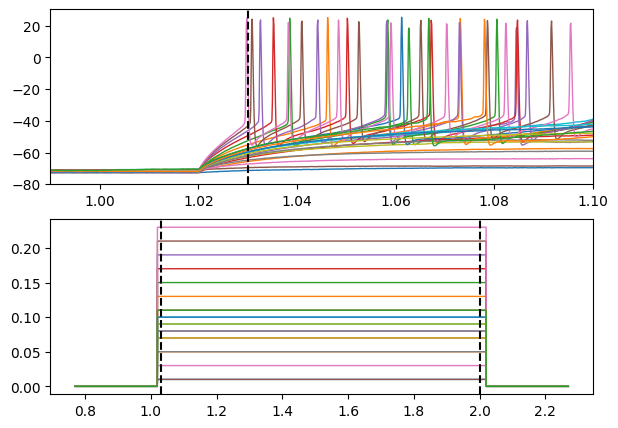

In [23]:
window0 = np.logical_and(positive_data[sweep_id]['target']['time'] >= 1.03, positive_data[sweep_id]['target']['time'] <= 2)
window1 = np.logical_and(positive_data[sweep_id]['target']['time'] >= 1.01, positive_data[sweep_id]['target']['time'] <= 1.05)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
for sweep_id in positive_data.keys():
    axes[0].plot(positive_data[sweep_id]['target']['time'], positive_data[sweep_id]['target']['voltage'],linewidth=1)
    axes[1].plot(positive_data[sweep_id]['target']['time'], positive_data[sweep_id]['target']['current'] / 1e3,linewidth=1)
for ax in axes:
    ax.axvline(positive_data['3']['target']['time'][window0][0], color='k', linestyle='--')
    ax.axvline(positive_data['3']['target']['time'][window0][-1], color='k', linestyle='--')
    # ax.axvline(positive_data['3']['target']['time'][window1][0], color='r', linestyle='--')
    # ax.axvline(positive_data['3']['target']['time'][window1][-1], color='r', linestyle='--')
axes[0].set_xlim(0.99,1.1)   
# window 0 stim, window 1 onset
active_windows = tuple([tuple(window0), tuple(window1)])


In [24]:
def initialize_parameters(bounds, random_seed = 1):
    """
    Randomly initialize parameters within specified bounds.
    Values are created as JAX arrays with float64 dtype.
    
    Args:
        for_bounds (list): List of dictionaries containing parameter names and their (min, max) bounds
        pct (float): Percentage of the (lower) range to use for random initialization (default 0.5)
        
    Returns:
        list: List of dictionaries with randomly initialized parameter values as JAX arrays
    """
    params = []
    random.seed(random_seed)
    for bound_dict in bounds:
        for param_name, value in bound_dict.items():
            lower = value.lower
            # specific to jax sigmoid transform
            upper = value.upper #width + lower
            # Generate random value within bounds and convert to JAX array
            random_value = uniform_log_scale(lower, upper, seed=random_seed)
            #random_value = random.uniform(lower + low_range_pct ,lower + range_pct) always returned value near upper allowed range
            value_array = jnp.array([random_value], dtype=jnp.float64)
            params.append({param_name: value_array})
    
    return params

In [25]:
# dataloader = Dataset(positive_data)

# def simulate_step(cell, params, amp, i_delay, i_dur, dt, t_max):
#     # currently only for step currents
#     #i_amp = jnp.array([jnp.max(jnp.abs(current))])
#     i_amp = amp #[jnp.max(jnp.abs(current))]
#     currents = jx.step_current(i_delay=i_delay, i_dur=i_dur, i_amp =i_amp, delta_t=dt, t_max=t_max)
#     # must use .data_stimulate not .stimulate when using vmapping
#     current_stim = cell.branch(0).loc(0.0).data_stimulate(current = currents)
#     return jx.integrate(cell, params=params, delta_t=dt, data_stimuli=current_stim, voltage_solver="jaxley.stone")
    
# batched_sim_step = vmap(simulate_step, in_axes=(None, None, 0, None, None, None, None))
# dataset_seed = 1
# batch_data, batch_current, batch_target, batch_amps = dataloader.get_batch(batch_size = 5, shuffle=True, seed=dataset_seed)

# batch_data[0]['input']['i_delay']
# i_delay = batch_data[0]['input']['i_delay']
# i_dur = batch_data[0]['input']['i_dur']
# dt = batch_data[0]['input']['dt']
# t_max = batch_data[0]['input']['t_max']

# cell.set('v', np.median(batch_target[:,0])) # set initial voltage to first time point of target voltage
# print('v', np.median(batch_target[:,0]))
# cell.set('Leak_eLeak', np.median(batch_target[:,0])) # set initial leak reversal potential to first time point of target voltage
# print('Leak_eLeak', np.median(batch_target[:,0]))
# cell.init_states()

# output_test = batched_sim_step(cell, params_init, batch_amps, i_delay, i_dur, dt, t_max)
# v_test = np.array(output_test[:,0,:])

In [26]:
# for sweep_id in positive_data.keys():
#     print(sweep_id, positive_data[sweep_id]['input']['i_amp'])

In [27]:
# voltage = positive_data['25']['target']['voltage']
# threshold = 2.0
# smoothness = 5.0 
# derivative = jnp.gradient(voltage)
# sigmoid = jax.nn.sigmoid(smoothness * (derivative - threshold))
# integral = trapezoid(sigmoid, dx=0.1)

# derivative = jnp.gradient(voltage)
# sigmoid = jax.nn.sigmoid(smoothness * (derivative - threshold))
# integral = trapezoid(sigmoid, dx=0.1)

# fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
# ax[0].plot( voltage, color='black', label='data')
# ax[0].set_ylabel('Voltage (mV)')
# ax[1].plot(derivative, color='black', label='data')
# ax[1].set_ylabel('dV/dt')
# ax[2].plot( sigmoid, color='black', label='data')
# ax[2].set_ylabel('Sigmoid')
# ax[2].set_xlabel('Time (ms)')

# print(integral)


### 2. Make cell, set passive parameters from previous fit, make active parameters and set appropriate bounds

In [28]:

if load_params:
    load_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/test_results/080325_passive_onsetOffset'    
    # load pass_params
    with open(os.path.join(load_dir, "params_constrained.pkl"), "rb") as file:
        passive_fits = pickle.load(file)
        
    min_loss_idx = min(passive_fits, key=lambda x: passive_fits[x]['loss'])
    pass_params = passive_fits[min_loss_idx]['params']
        

    fit_params = {}
    pass_bound_names = ['soma_capacitance', 
                        'basal_capacitance', 
                        'axon_capacitance', 
                        'axial_resistivity',
                        'soma_gLeak',
                        'basal_gLeak',
                        'axon_gLeak',
                        'eLeak']

    for i in range(len(pass_params)):
        for key, value in pass_params[i].items():
            print(key, pass_bound_names[i], value)
            fit_params[pass_bound_names[i]] = value
else:
        
    fit_params = {}
    pass_bound_names = ['soma_capacitance', 
                        'basal_capacitance', 
                        'axon_capacitance', 
                        'axial_resistivity',
                        'soma_gLeak',
                        'basal_gLeak',
                        'axon_gLeak']

    for i in range(len(pass_params)):
        for key, value in pass_params[i].items():
            print(key, pass_bound_names[i], value)
            fit_params[pass_bound_names[i]] = value

capacitance soma_capacitance [0.96982741]
capacitance basal_capacitance [0.95934405]
capacitance axon_capacitance [0.8933619]
axial_resistivity axial_resistivity [139.97501114]
Leak_gLeak soma_gLeak [6.87321793e-05]
Leak_gLeak basal_gLeak [7.99456335e-05]
Leak_gLeak axon_gLeak [0.00013601]


In [29]:
nseg_per_branch = 1
cell = jx.read_swc(swc_file, nseg_per_branch, max_branch_len=20000.0, assign_groups=True)

# Set free parameter bounds, for first run, copy distributions from Allen biophysical all-active model fitting

bounds = [
    # {'capacitance': custom_SigmoidTransform(0.5, 10)},
    # {'axial_resistivity': custom_SigmoidTransform(50, 150)},
    # {'Leak_gLeak': custom_SigmoidTransform(1e-7, 1e-2)},
    # {'Leak_eLeak': custom_SigmoidTransform(-110, -60)},
    
    # added in from perisomatic model mechanisms
   # {'soma_M_gM': custom_SigmoidTransform(1e-7, 1e-2)},
   #{'soma_K_P_gK_P': custom_SigmoidTransform(1e-4, 1e-1)},
    {'soma_Im_v2_gIm_v2': LogSpaceTransform(1e-7, 1e-2)},
    {'soma_Kv2like_gKv2like': LogSpaceTransform(1e-7, 1e-1)},
    {'soma_Kd_gKd': LogSpaceTransform(1e-7, 1e-2)},
    {'soma_K_T_gK_T': LogSpaceTransform(1e-7, 1e-2)},
    {'soma_H_gH': LogSpaceTransform(1e-7, 1e-5)},
    # {'soma_NaV_gNaV': LogSpaceTransform(1e-5, 1)},
    {'soma_NaTs_gNaTs': LogSpaceTransform(1e-5, 1)},
    {'soma_Nap_gNap': LogSpaceTransform(1e-7, 5e-2)},
    {'soma_SKE2_gSKE2': LogSpaceTransform(1e-7, 1e-2)},
    {'soma_SKv3_1_gSKv3_1': LogSpaceTransform(1e-7, 1)},
    {'soma_CaHVA_gCaHVA': LogSpaceTransform(1e-7, 1e-2)},
    {'soma_CaLVA_gCaLVA': LogSpaceTransform(1e-7, 1e-4)},
    {'soma_CaPump_gamma': LogSpaceTransform(5e-4, 5e-2)},
    {'soma_CaPump_decay': LogSpaceTransform(10, 1000)},
    # {'basal_H_gH': custom_SigmoidTransform(1e-7, 1e-5)},
    # {'basal_NaTs_gNaTs': custom_SigmoidTransform(1e-7, 5e-2)},
    # {'basal_Nap_gNap': custom_SigmoidTransform(1e-7, 5e-2)},
    # {'basal_SKv3_1_gSKv3_1': custom_SigmoidTransform(1e-7, 1)},
    # {'basal_Im_v2_gIm_v2': custom_SigmoidTransform(1e-7, 1e-2)},
    # {'axon_NaTs_gNaTs': custom_SigmoidTransform(1e-7, 1)},
    # {'axon_Nap_gNap': custom_SigmoidTransform(1e-7, 5e-2)},
    # {'axon_Kd_gKd': custom_SigmoidTransform(1e-7, 1e-2)},
    # {'axon_Kv2like_gKv2like': custom_SigmoidTransform(1e-7, 1e-1)},
    # {'axon_K_T_gK_T': custom_SigmoidTransform(1e-7, 1e-2)},
    # {'axon_SKE2_gSKE2': custom_SigmoidTransform(1e-7, 1e-2)},
    # {'axon_SKv3_1_gSKv3_1': custom_SigmoidTransform(1e-7, 1)},
    # {'axon_CaHVA_gCaHVA': custom_SigmoidTransform(1e-7, 1e-2)},
    # {'axon_CaLVA_gCaLVA': custom_SigmoidTransform(1e-7, 1e-4)},
    # {'axon_CaPump_gamma': custom_SigmoidTransform(5e-4, 5e-2)},
    # {'axon_CaPump_decay': LogSpaceTransform(10, 1000)}
]


# Some electrophysiological parameters can be determined from the electrophysiology data
# For example, the resting potential can be set to the average resting potential of the cell

# insert active channels into only the soma, elsewhere only has passive currents: 
# will want to figure out how to obtain the values for these from the allen models automatically (fit_parameters.json)

# test with no constraints, but can then set upper & lower bounds for each conductance
init_v = float(positive_data['3']['target']['voltage'][0])
cell.set("v", init_v) # initial voltage

##########PASSIVE###############

# Capacitance (cm)

cell.soma.set('capacitance', float(fit_params['soma_capacitance'][0])) #uF/cm^2
cell.basal.set('capacitance', float(fit_params['basal_capacitance'][0])) #uF/cm^2
cell.axon.set('capacitance', float(fit_params['axon_capacitance'][0])) #uF/cm^2
#cell.make_trainable('capacitance')

# Axial resistance (Ra)
cell.set('axial_resistivity', float(fit_params['axial_resistivity'][0])) # ohm cm
# cell.make_trainable('axial_resistivity')

# Leak
cell.insert(Leak())
cell.soma.set('Leak_gLeak', float(fit_params['soma_gLeak'][0]))
cell.basal.set('Leak_gLeak', float(fit_params['basal_gLeak'][0]))
cell.axon.set('Leak_gLeak', float(fit_params['axon_gLeak'][0]))
# cell.make_trainable('Leak_gLeak')
# cell.make_trainable('Leak_eLeak')

##########ACTIVE###############

# Soma
#    #M
# cell.soma.insert(M().change_name("soma_M"))
# cell.soma.set('soma_M_gM', 0.0001)
# cell.make_trainable('soma_M_gM')
#     # K_P
# cell.soma.insert(K_P().change_name("soma_K_P"))
# cell.soma.set('soma_K_P_gK_P', 0.0001)
# cell.make_trainable('soma_K_P_gK_P')
cell.soma.insert(Im_v2().change_name("soma_Im_v2"))
cell.soma.set('soma_Im_v2_gIm_v2', 0.0001)
cell.make_trainable('soma_Im_v2_gIm_v2')
cell.soma.insert(Kv2like().change_name("soma_Kv2like"))
cell.soma.set('soma_Kv2like_gKv2like', 0.0001)
cell.make_trainable('soma_Kv2like_gKv2like')
cell.soma.insert(Kd().change_name("soma_Kd"))
cell.soma.set('soma_Kd_gKd', 0.0001)
cell.make_trainable('soma_Kd_gKd')


#     # K_T
cell.soma.insert(K_T().change_name("soma_K_T"))
cell.soma.set('soma_K_T_gK_T', 0.0001)
cell.make_trainable('soma_K_T_gK_T')
#     #Ih
cell.soma.insert(H().change_name("soma_H"))
cell.soma.set('soma_H_gH', 3e-06)
cell.make_trainable('soma_H_gH')
# cell.soma.insert(NaV().change_name("soma_NaV"))
# cell.soma.set('soma_NaV_gNaV', 3e-06)
# cell.make_trainable('soma_NaV_gNaV')
# #     # NaTs, replacing Nav
cell.soma.insert(NaTs().change_name("soma_NaTs"))
cell.soma.set('soma_NaTs_gNaTs', 5e-3)
cell.make_trainable('soma_NaTs_gNaTs')
# #     #NaP
cell.soma.insert(Nap().change_name("soma_Nap"))
cell.soma.set('soma_Nap_gNap', 3e-06)
cell.make_trainable('soma_Nap_gNap')
#     # SK
cell.soma.insert(SKE2().change_name("soma_SKE2"))
cell.soma.set('soma_SKE2_gSKE2', 0.0004)
cell.make_trainable('soma_SKE2_gSKE2')
#     # Kv3_1
cell.soma.insert(SKv3_1().change_name("soma_SKv3_1"))
cell.soma.set('soma_SKv3_1_gSKv3_1', 0.03)
cell.make_trainable('soma_SKv3_1_gSKv3_1')
# #     # Ca_HVA
cell.soma.insert(CaHVA().change_name("soma_CaHVA"))
cell.soma.set('soma_CaHVA_gCaHVA', 1e-05)
cell.make_trainable('soma_CaHVA_gCaHVA')
#     # Ca_LVA
cell.soma.insert(CaLVA().change_name("soma_CaLVA"))
cell.soma.set('soma_CaLVA_gCaLVA', 1e-5)
cell.make_trainable('soma_CaLVA_gCaLVA')
# Ca pump
cell.soma.insert(CaPump().change_name("soma_CaPump")) # shell depth matches allen
cell.soma.set('soma_CaPump_gamma', 5e-3)
cell.make_trainable('soma_CaPump_gamma')
cell.soma.set('soma_CaPump_decay', 589)
cell.make_trainable('soma_CaPump_decay')

# # Dendrites
# #     #Ih
# cell.basal.insert(H().change_name("basal_H"))
# cell.basal.set('basal_H_gH', 3e-06)
# cell.make_trainable('basal_H_gH')
# #     #NaTs
# cell.basal.insert(NaTs().change_name("basal_NaTs"))
# cell.basal.set('basal_NaTs_gNaTs', 5e-3)
# cell.make_trainable('basal_NaTs_gNaTs')
# #     #NaP
# cell.basal.insert(Nap().change_name("basal_Nap"))
# cell.basal.set('basal_Nap_gNap', 0.0003)
# cell.make_trainable('basal_Nap_gNap')
# #     #SKv3_1
# cell.basal.insert(SKv3_1().change_name("basal_SKv3_1"))
# cell.basal.set('basal_SKv3_1_gSKv3_1', 0.03)
# cell.make_trainable('basal_SKv3_1_gSKv3_1')
# #     #M
# cell.basal.insert(Im_v2().change_name("basal_Im_v2"))
# cell.basal.set('basal_Im_v2_gIm_v2', 0.0001)
# cell.make_trainable('basal_Im_v2_gIm_v2')

# # Axon
# #     #NaTs
# cell.axon.insert(NaTs().change_name("axon_NaTs"))
# cell.axon.set('axon_NaTs_gNaTs', 5e-3)
# cell.make_trainable('axon_NaTs_gNaTs')
# #     #NaP
# cell.axon.insert(Nap().change_name("axon_Nap"))
# cell.axon.set('axon_Nap_gNap', 0.0003)
# cell.make_trainable('axon_Nap_gNap')
# #     #Kd
# cell.axon.insert(Kd().change_name("axon_Kd"))
# cell.axon.set('axon_Kd_gKd', 0.0001)
# cell.make_trainable('axon_Kd_gKd')
# #     #Kv2like
# cell.axon.insert(Kv2like().change_name("axon_Kv2like"))
# cell.axon.set('axon_Kv2like_gKv2like', 0.01)
# cell.make_trainable('axon_Kv2like_gKv2like')
# #   #K_T
# cell.axon.insert(K_T().change_name("axon_K_T"))
# cell.axon.set('axon_K_T_gK_T', 0.0001)
# cell.make_trainable('axon_K_T_gK_T')
# #     #SK
# cell.axon.insert(SKE2().change_name("axon_SKE2"))
# cell.axon.set('axon_SKE2_gSKE2', 0.0001)
# cell.make_trainable('axon_SKE2_gSKE2')
# #     #SKv3_1
# cell.axon.insert(SKv3_1().change_name("axon_SKv3_1"))
# cell.axon.set('axon_SKv3_1_gSKv3_1', 0.03)
# cell.make_trainable('axon_SKv3_1_gSKv3_1')
# #     #Ca_HVA
# cell.axon.insert(CaHVA().change_name("axon_CaHVA"))
# cell.axon.set('axon_CaHVA_gCaHVA', 1e-05)
# cell.make_trainable('axon_CaHVA_gCaHVA')
# #     #Ca_LVA
# cell.axon.insert(CaLVA().change_name("axon_CaLVA"))
# cell.axon.set('axon_CaLVA_gCaLVA', 1e-5)
# cell.make_trainable('axon_CaLVA_gCaLVA')
# #     #Ca pump
# cell.axon.insert(CaPump().change_name("axon_CaPump"))
# cell.axon.set('axon_CaPump_gamma', 5e-3)
# cell.make_trainable('axon_CaPump_gamma')
# cell.axon.set('axon_CaPump_decay', 589)
# cell.make_trainable('axon_CaPump_decay')

# reversal potentials & concentrations
# shared channel parameters overwrite eachother, set final parameter values after adding all the channels
# these values were obtained from the Allen biophysical models white pages
cell.insert(CaNernstReversal())
cell.set('eK', -107.0)
cell.set('eNa', 53.0)
cell.set('CaCon_e', 2) # mM units
cell.set('CaCon_i', 1e-04) # mM units
cell.set("celsius", 34) # temperature

cell.delete_stimuli()
# record from the soma
cell.branch(0).comp(0).record("v",verbose=True)
# cell.branch(0).comp(0).record("CaCon_i", verbose=True)
# cell.branch(0).comp(0).record("eCa", verbose=True)
cell.branch(0).comp(0).recordings



/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/Miniforge/envs/jax_gpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning: Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.
  warn(


Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Number of newly added trainable parameters: 1. Total number of trainable parameters: 4
Number of newly added trainable parameters: 1. Total number of trainable parameters: 5
Number of newly added trainable parameters: 1. Total number of trainable parameters: 6
Number of newly added trainable parameters: 1. Total number of trainable parameters: 7
Number of newly added trainable parameters: 1. Total number of trainable parameters: 8
Number of newly added trainable parameters: 1. Total number of trainable parameters: 9
Number of newly added trainable parameters: 1. Total number of trainable parameters: 10
Number of newly added trainable parameters: 1. Total number of trainable parameters: 11
Number of newly added trainable parameter

,rec_index,state
0,0,v


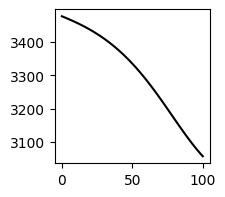

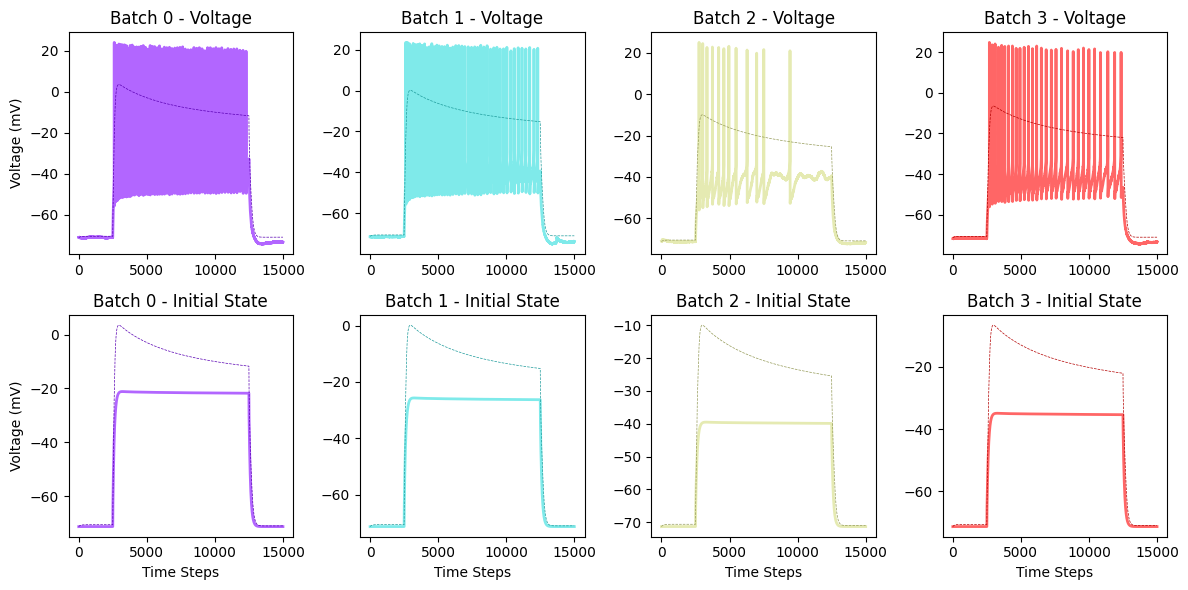

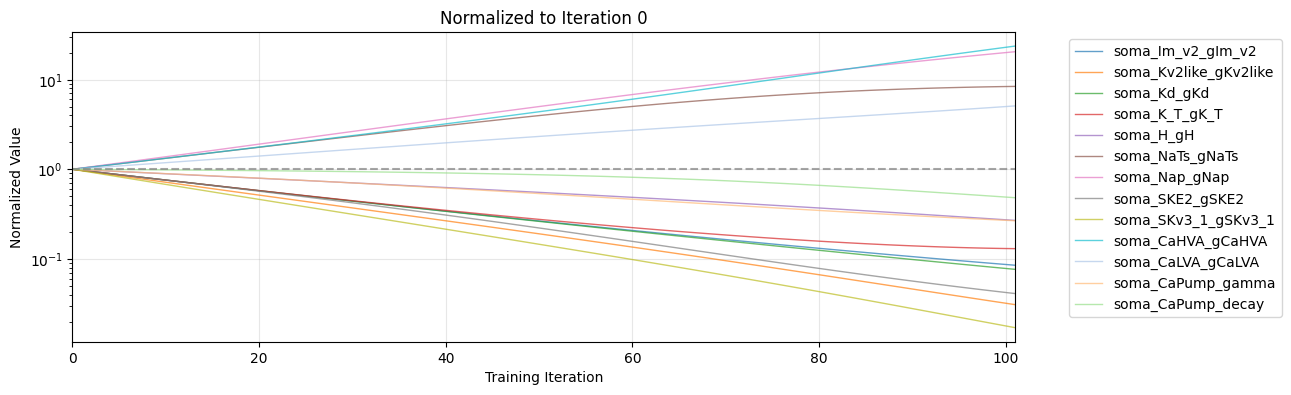

Step time: 35.3521, Patience: 0
loss in epoch 101: 3053.0628
All losses: {'dvdt_loss': Array(98.83562655, dtype=float64), 'max_error': Array(130.49744539, dtype=float64), 'mean_error': Array(56.95969382, dtype=float64), 'min_error': Array(10.47854079, dtype=float64), 'spike_int_diff': Array(2756.29146668, dtype=float64)}
Step time: 35.3439, Patience: 0
loss in epoch 102: 3048.7077
All losses: {'dvdt_loss': Array(100.09522028, dtype=float64), 'max_error': Array(124.00691821, dtype=float64), 'mean_error': Array(57.59844465, dtype=float64), 'min_error': Array(10.73775115, dtype=float64), 'spike_int_diff': Array(2756.2693402, dtype=float64)}
Step time: 35.3512, Patience: 0
loss in epoch 103: 3044.5022
All losses: {'dvdt_loss': Array(101.37186026, dtype=float64), 'max_error': Array(117.64190925, dtype=float64), 'mean_error': Array(58.23797702, dtype=float64), 'min_error': Array(11.00414113, dtype=float64), 'spike_int_diff': Array(2756.24633376, dtype=float64)}
Step time: 35.3725, Patience: 

In [30]:
active_fits = {}
seeds = [1,10, 100,1000,1234, 2222, 3333] #np.arange(0, 5) 
config.update("jax_platform_name", "gpu")
save_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/test_results/090325_active_all_kchannelsNarrow_lr0.01'

    # _, pass_params, pass_loss, pass_metrics = batched_stepCurrent_training(pass_cell, pass_bounds, passive_data, passive_windows, batches = 1, 
    #                                                                     batch_size = 1, steps = 500, 
    #                                                                     learning_rate = 0.1, beta = 0.8, 
    #                                                                     required_loss = 0.5, 
    #                                                                     patience_max = 50, plot_num = 20)
for i in seeds:
    # _, active_params, active_loss, active_metrics = batched_stepCurrent_training(cell, bounds, active_start_data, transient_windows, train_type = 'active', 
    #                                                                              batches = 1, batch_size = 4, steps = 1000, random_seeds = [int(i)], 
    #                                                                             learning_rate = 0.1, beta = 0.8, required_loss = 1, 
    #                                                                             patience_max = 50, plot_num = 50, dataset_seed= 3, savedir = save_dir)
    
    _, active_params, active_loss, active_metrics = batched_stepCurrent_training(cell, bounds, extra_positive_data, active_windows, train_type = 'active', 
                                                                                 batches = 1, batch_size = 4, steps = 400, random_seeds = [int(i)], 
                                                                                learning_rate = 0.01, beta = 0.8, required_loss = 1, 
                                                                                patience_max = 200, plot_num = 100, dataset_seed= 3, savedir = save_dir)
    
    batch_info = {'params': active_params, 'loss': active_loss, 'metrics': active_metrics}
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    file_name = f"Fit_data_{i}.pkl"   
    file_name = file_name.replace("[","").replace("]","").replace(" ","_") 
    with open(os.path.join(save_dir, file_name), "wb") as handle:
        pickle.dump(batch_info, handle)
    
    active_fits[i] = {'params': active_params, 'loss': active_loss, 'metrics': active_metrics}
    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
file_name = f"Fit_data_{seeds}.pkl"   
file_name = file_name.replace("[","").replace("]","").replace(" ","_") 
with open(os.path.join(save_dir, file_name), "wb") as handle:
    pickle.dump(active_fits, handle)

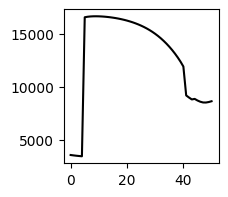

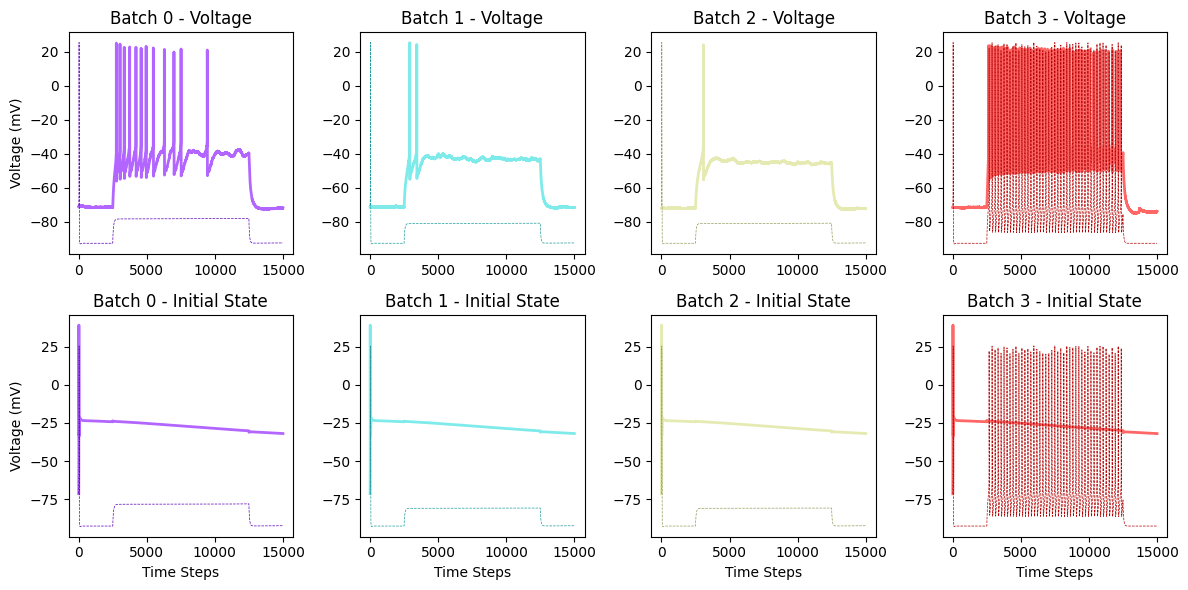

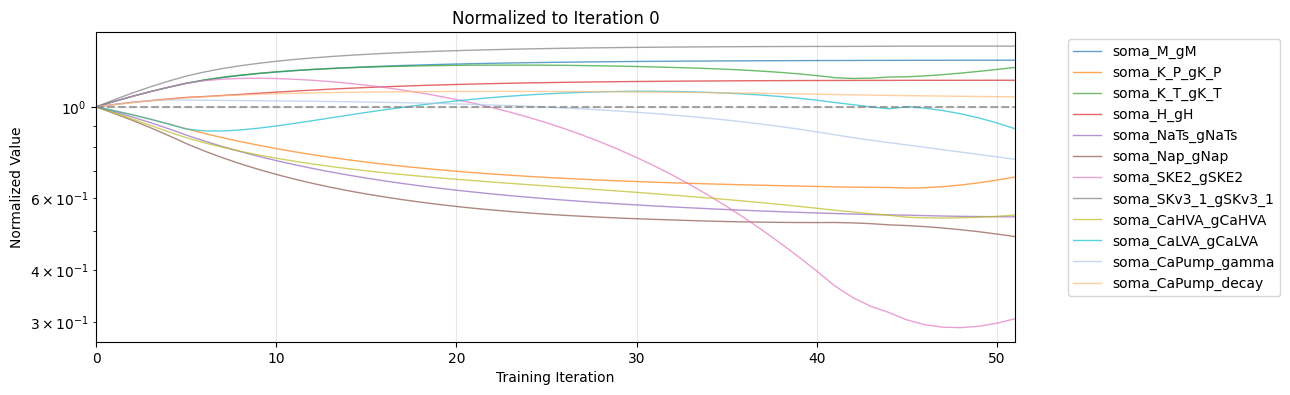

Step time: 33.4488, Patience: 47
loss in epoch 51: 8749.4300
All losses: {'dvdt_loss': Array(1365.66899046, dtype=float64), 'max_error': Array(5810.53342062, dtype=float64), 'mean_error': Array(28.4872871, dtype=float64), 'min_error': Array(917.74202173, dtype=float64), 'spike_int_diff': Array(73.90923312, dtype=float64), 'start_MSE': Array(553.08900645, dtype=float64)}
Step time: 33.4103, Patience: 48
loss in epoch 52: 8882.5578
All losses: {'dvdt_loss': Array(1384.36129375, dtype=float64), 'max_error': Array(5897.48478871, dtype=float64), 'mean_error': Array(28.959401, dtype=float64), 'min_error': Array(946.74106703, dtype=float64), 'spike_int_diff': Array(64.02688903, dtype=float64), 'start_MSE': Array(560.98432977, dtype=float64)}
Step time: 33.4344, Patience: 49
loss in epoch 53: 9007.4844
All losses: {'dvdt_loss': Array(1393.25321049, dtype=float64), 'max_error': Array(5992.55943715, dtype=float64), 'mean_error': Array(29.27778376, dtype=float64), 'min_error': Array(980.83813644,

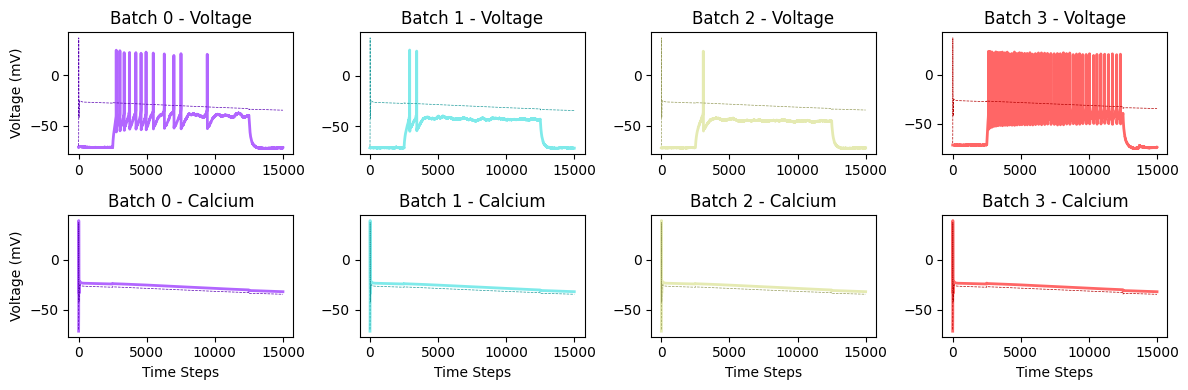

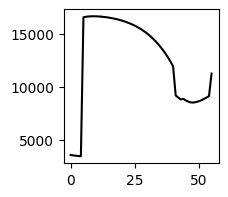

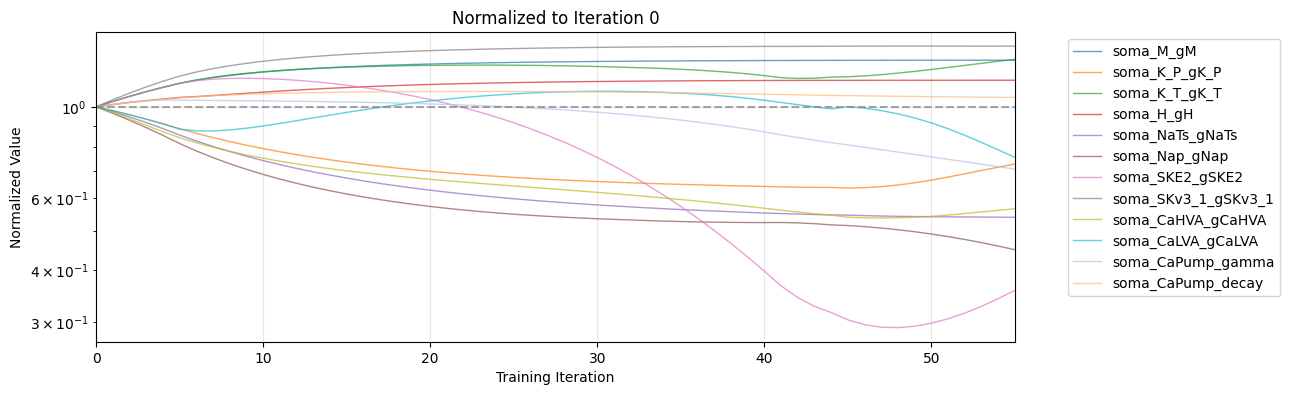

In [24]:
#os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".9"
#random.seed(1)
active_fits = {}
seeds = np.arange(0, 5)
config.update("jax_platform_name", "gpu")

    # _, pass_params, pass_loss, pass_metrics = batched_stepCurrent_training(pass_cell, pass_bounds, passive_data, passive_windows, batches = 1, 
    #                                                                     batch_size = 1, steps = 500, 
    #                                                                     learning_rate = 0.1, beta = 0.8, 
    #                                                                     required_loss = 0.5, 
    #                                                                     patience_max = 50, plot_num = 20)
for i in seeds:
    _, active_params, active_loss, active_metrics = batched_stepCurrent_training(cell, bounds, positive_data, subthresh_windows, train_type = 'active', 
                                                                                 batches = 1, batch_size = 4, steps = 200, random_seeds = [int(i)], 
                                                                                learning_rate = 0.1, beta = 0.8, required_loss = 1, 
                                                                                patience_max = 50, plot_num = 10, dataset_seed= 0)
    active_fits[i] = {'params': active_params, 'loss': active_loss, 'metrics': active_metrics}
    
save_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/test_results/060325_active_onsetOffset'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
file_name = f"Fit_data_{seeds}.pkl"   
file_name = file_name.replace("[","").replace("]","").replace(" ","_") 
with open(os.path.join(save_dir, file_name), "wb") as handle:
    pickle.dump(active_fits, handle)

In [36]:
# load fit data
save_dir = '/allen/programs/mindscope/workgroups/realistic-model/elena.westeinde/patchseq/patchseq_models/test_results/260225_active'
file_name = 'Fit_data_0_1_2.pkl'
with open(os.path.join(save_dir, file_name), "rb") as handle:
    prev_fits = pickle.load(handle)

In [39]:
print(prev_fits[0])

{'capacitance': Array([5.43239365], dtype=float64)}


(20000,)


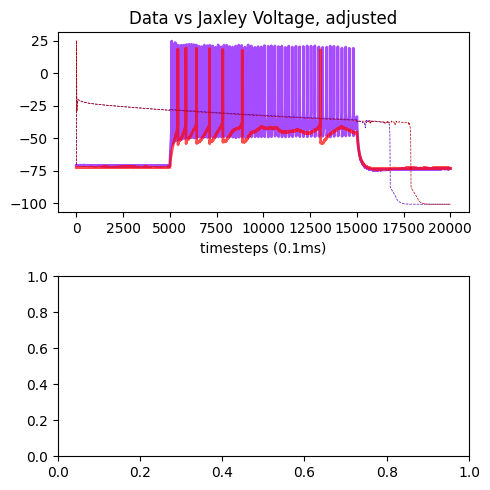

In [33]:
dataloader = Dataset(active_data)
min_loss_idx = min(active_fits, key=lambda x: active_fits[x]['loss'])
idx = 2
best_params = active_fits[idx]['params']
current = active_fits[idx]['metrics'][0]['current']
target = active_fits[idx]['metrics'][0]['target']
batch_data, _, _ = dataloader.get_batch(batch_size = 1, shuffle=True)
i_delay = batch_data[0]['input']['i_delay']
i_dur = batch_data[0]['input']['i_dur']
dt = batch_data[0]['input']['dt']
t_max = batch_data[0]['input']['t_max']

batched_output = batched_sim_step(cell, best_params, current, i_delay, i_dur, dt, t_max)

jax_v = batched_output[:,0,:]
# repeat target time for each trace in batch
#target_time = jnp.repeat(jnp.expand_dims(batch_data[0]['target']['time'], axis=0), 5, axis=0)

batch_size = current.shape[0]
colors = plt.cm.rainbow(np.linspace(0, 1, batch_size))
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
# _ = ax[0].plot(batch_target.T, linewidth=0.5)
# _ = ax[0].plot(jax_v[:,2:].T, c="k", linestyle="--")
for i in range(batch_size):
    _ = ax[0].plot(target[i], color=colors[i], alpha=0.7, linewidth=2)
    darker_color = np.array(colors[i])
    darker_color[:3] *= 0.7
    _ = ax[0].plot(jax_v[i, 2:], linestyle="--", color=darker_color, linewidth=0.5)
_ = ax[0].set_xlabel("timesteps (0.1ms)")
_ = ax[0].set_title("Data vs Jaxley Voltage, adjusted")

plt.tight_layout()
plt.show()

In [44]:
# batch_size =2
# active_data = make_data_dict(sweep_ids, ephys_data, sweep_features, stim_time=None, pre_stim=500, 
#                post_stim=500, dt = 0.1, new_dt=0.0001)

# print(active_data['0']['input'].keys())

# ids = list(active_data.keys())
# for id in ids:
#     if len(active_data[id]['target']['voltage']) != 20000:
#         del active_data[id]
        
transform = ParamTransform(pass_bounds)            
dataloader = Dataset(passive_data)

batch_data, batch_current, batch_target = dataloader.get_batch(batch_size = 2, shuffle=True)

i_delay = batch_data[0]['input']['i_delay']
i_dur = batch_data[0]['input']['i_dur']
dt = batch_data[0]['input']['dt']
t_max = batch_data[0]['input']['t_max']
pre_length = batch_data[0]['input']['pre_stim_length']
post_length = batch_data[0]['input']['post_stim_length']

# print(batch_data[0]['input'].keys())

# pre_stim_length = batch_data[0]['input']['pre_stim_length']
# post_stim_length = batch_data[0]['input']['post_stim_length']

# print(pre_stim_length, post_stim_length)
params = cell.get_parameters()
# test2_params = transform.forward(transform.inverse(params))
# opt_params =  transform.inverse(params)
# for_params = transform.forward(opt_params)
# test_params = init(opt_params, init_params=None) 
# init_for_params = transform.forward(test_params)

batched_output = batched_sim_step(pass_cell, params, batch_current, i_delay, i_dur, dt, t_max)

test = jnp.std(batch_target, axis=1)
test2 = jnp.std(batched_output[:,0,:], axis=1)


# # #def loss_from_v_batched(batched_output, batched_v, i_delay, i_dur, dt, t_max, prepost_weight):
# # v = batched_output[:,0,:]

# # pre_stop = jnp.int32(i_delay/dt - 100)
# # post_start = jnp.int32(i_delay/dt + i_dur/dt + 1000)

# # if v.shape[1] != batched_v.shape[1]:
# #     diff = v.shape[1] - batched_v.shape[1]
# #     v = jnp.where(diff > 0, v[:, diff:], v[:, :batched_v.shape[1]])
# # batch_num = jnp.size(v,axis=0)
# # pre_stim_start = jnp.zeros(batch_num).astype('int32')
# # post_stim_start = jnp.zeros(batch_num).astype('int32') + jnp.int32(i_delay/dt + i_dur/dt) + 1000

# # pre_v = jax.vmap(lambda x, s: jax.lax.dynamic_slice(x, (s,), (jnp.int32(pre_length),)))(v, pre_stim_start)
# # post_v = jax.vmap(lambda x, s: jax.lax.dynamic_slice(x, (s,), (jnp.int32(post_length),)))(v, post_stim_start)

# # pre_batched_v = jax.vmap(lambda x, s: jax.lax.dynamic_slice(x, (s,), (jnp.int32(pre_length),)))(batched_v, pre_stim_start)
# # post_batched_v = jax.vmap(lambda x, s: jax.lax.dynamic_slice(x, (s,), (jnp.int32(post_length),)))(batched_v, post_stim_start)

# # baseline_loss = jnp.mean(jnp.abs(pre_v - pre_batched_v)) + jnp.mean(jnp.abs(post_v - post_batched_v))
# # voltage_loss = jnp.mean(jnp.abs(v - batched_v))

# #return voltage_loss + prepost_stim_loss * prepost_weight


# # pre_stim_loss = jnp.mean(jnp.abs(v[:, :pre_stop] - batched_v[:, :pre_stop]))
# # post_stim_loss = jnp.mean(jnp.abs(v[:, post_start:] - batched_v[:, post_start:]))
# # prepost_stim_loss = pre_stim_loss + post_stim_loss
# # voltage_loss = jnp.mean(jnp.abs(v - batched_v))
# #     #return voltage_loss + prepost_stim_loss * prepost_weight


# fig, ax = plt.subplots(2, 1, figsize=(5, 5))
# _ = ax[0].plot(batched_output[:,0,:].T)
# _ = ax[1].plot(batch_target.T)
# _ = ax[1].plot(post_target[0,:])
#_ = ax[1].axvline(pre_stim_idx[0], color='r')
#_ = ax[1].axvline(pre_stim_idx[1], color='r')

# _ = ax[1].axvline(post_stim_idx[0], color='r')
# _ = ax[1].axvline(post_stim_idx[1], color='r')


(1149,)
(1149,)


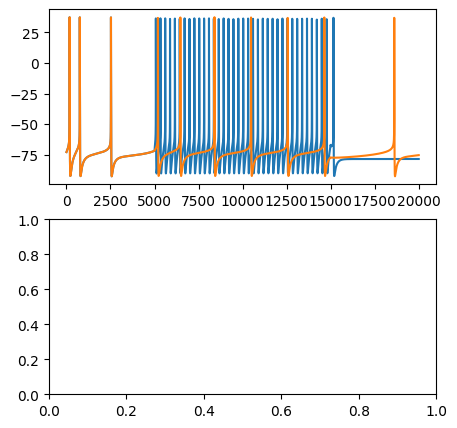

In [56]:

        # batched_output shape = (batch_size, rec types, n_time_steps)
v = batched_output[:,0,:]
batched_v = batch_target

# jaxley output has 1-2 extra time steps compared to the bmtk data, not sure why
if v.shape[1] != batched_v.shape[1]:
    diff = v.shape[1] - batched_v.shape[1]
    v = jnp.where(diff > 0, 
                    v[:, diff:],
                    v[:, :batched_v.shape[1]])
    voltage_loss = jnp.abs(v - batched_v) 
    combined_loss = jnp.mean(voltage_loss)

    print((jnp.sum(voltage_loss, axis=1)/voltage_loss.shape[1])/2)
    print(combined_loss)


# fig, ax = plt.subplots(2, 1, figsize=(5, 5))
# _ = ax[0].plot(batched_output[:,0,:].T)
# # _ = ax[0].plot(jax_v[2:], c="y", linestyle="--")

# fig, ax = plt.subplots(2, 1, figsize=(5, 5))
# _ = ax[0].plot(batch_target.T)

[10.65849814 13.87480762]
12.26665287921973


Simulation time 10.166569471359253


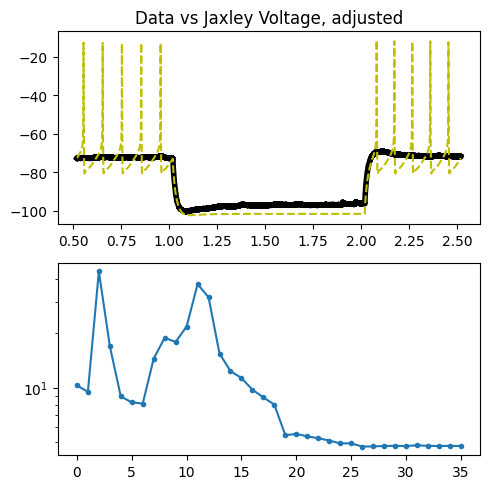

Step 36 time: 44.28
loss in epoch 36: 4.7061, gradient_norm 73730.2704, corrected 9.4087
Step 37 time: 44.26
loss in epoch 37: 4.6908, gradient_norm 72772.1817, corrected 9.3841
Step 38 time: 44.27
loss in epoch 38: 4.7115, gradient_norm 67735.7159, corrected 9.2505
Step 39 time: 44.25
loss in epoch 39: 5.0679, gradient_norm 3350720.4216, corrected 20.1849


KeyboardInterrupt: 

In [54]:
losses = []  # Stores loss trajectories for each random start
epoch_list = []
best_traces = []                     # Stores best-fitting voltage traces
best_losses = []                     # Stores lowest loss achieved for each start
all_best_params = []                 # Stores optimal parameters found
total_sims = 0                       # Counter for total simulations run
beta = 0.8                           # Gradient normalization power factor
epochs = 1000   
learning_rate = 0.5  
transform = ParamTransform(bounds)            

seed = 1
_ = np.random.seed(seed)

params = cell.get_parameters()
opt_params =  transform.inverse(params)

opt_params = init(opt_params) # set random initial parameters
optimizer = optax.adam(learning_rate= learning_rate)
opt_state = optimizer.init(opt_params)

train_losses = []
grad_norms = []
epoch = 0
best_loss = 10000.0
plot_count = 0 
required_losses = [12, 5, 1]
patience = 0
# for iteration in range(2): 
#     if iteration > 0 and best_loss > required_losses[iteration-1]:
#         break
for epoch in range(epochs):
    
    t0 = time.time()
    # if set bounds on trainable params will need to transform in & out of constrained space
    params = transform.forward(opt_params)
    loss_val, grad_val = grad_fn(cell, params, target_v, dt)
    losses.append(loss_val)
    epoch_list.append(epoch)
    total_sims += 1
    
    # if loss_val < 5:
    #     learning_rate_new = 0.001
    if loss_val < 1:
        learning_rate_new = 0.05
    elif loss_val < 5:
        learning_rate_new = 0.1
    elif loss_val > 5:
        learning_rate_new = 0.5
        
    if learning_rate_new != learning_rate:
        optimizer = optax.adam(learning_rate= learning_rate_new)
        
    if loss_val < best_loss:
        best_loss = loss_val
        #best_params = tree_map(jnp.array, opt_params)  # Explicit JAX copy
        # Convert JAX arrays to Python floats
        best_params = opt_params
        patience = 0
    else:
        patience += 1
        # [
        #     {k: float(v[0]) for k, v in d.items()}
        #     for d in opt_params
        # ]
#         with open(os.path.join(save_dir, "opt_params_unconstrained.pkl"), "wb") as handle:
#             pickle.dump(opt_params, handle)

    grad_norm = l2_norm(grad_val)
    grad_val = tree_map(lambda x: x / grad_norm**beta * 1.0, grad_val) 
    grad_norm_corrected = l2_norm(grad_val)
    train_losses.append(loss_val)
    # Stop early if loss is below required threshold
    if loss_val < 0.1 or patience > 20: #required_losses[iteration]:
        break
    
    updates, opt_state = optimizer.update(grad_val, opt_state)
    update_norm = l2_norm(updates)
    opt_params = optax.apply_updates(opt_params, updates)
    grad_norms.append(grad_norm)
    
    print(f"Step {epoch} time: {time.time() - t0:.2f}")
    # if epoch % 5 == 0:
    print(f"loss in epoch {epoch}: {loss_val:.4f}, gradient_norm {grad_norm:.4f}, corrected {grad_norm_corrected:.4f}")
    
    # if plot_count == 5:
    #     # Clear the current pass_cell output
    #     clear_output(wait=True)
    #     plot_count = 0
    if epoch % 5 == 0:
        clear_output(wait=True)
        t0 = time.time()
        params = transform.forward(opt_params)
        #params = jnp.expand_dims(params, axis=0) # Add batch dimension if needed
        output = jitted_sim(cell, params, dt)
        #output = vmapped_sim(params, dt) # becomes useful when running multiple simulations in parallel
        print("Simulation time", time.time() - t0)

        jax_v = np.array(output[0].T)

        fig, ax = plt.subplots(2, 1, figsize=(5, 5))
        _ = ax[0].plot(target_time, target_v, c="k", linewidth=4)
        _ = ax[0].plot(target_time,jax_v[2:], c="y", linestyle="--")
        _ = ax[1].plot(epoch_list,losses, marker=".") #, marker="o")
        _ = ax[1].set_yscale('log')
        # _ = ax[0,1].set_xlim([5000, 8200])
        # _ = ax[0,1].set_ylim([-70, -40])
        # _ = ax[0,2].set_xlim([8000, 17000])
        # _ = ax[0,2].set_ylim([-40, -20])
        # set figure title
        _ = ax[0].set_title("Data vs Jaxley Voltage, adjusted")

        plt.tight_layout()
        plt.show()
        
        plot_count += 1
        epoch += 1
        
        
params = transform.forward(best_params)
#params = jnp.expand_dims(params, axis=0) # Add batch dimension if needed
output = jitted_sim(cell, params, dt)
#output = vmapped_sim(params, dt) # becomes useful when running multiple simulations in parallel
print("Simulation time", time.time() - t0)

jax_v = np.array(output[0].T)

fig, ax = plt.subplots(2, 1, figsize=(5, 5))
_ = ax[0].plot(target_time, target_v, c="k", linewidth=4)
_ = ax[0].plot(target_time,jax_v[2:], c="y", linestyle="--")
_ = ax[1].plot(epoch_list,losses, marker=".") #, marker="o")
# _ = ax[0,1].set_xlim([5000, 8200])
# _ = ax[0,1].set_ylim([-70, -40])
# _ = ax[0,2].set_xlim([8000, 17000])
# _ = ax[0,2].set_ylim([-40, -20])
# set figure title
_ = ax[0].set_title("Data vs Jaxley Voltage, adjusted")
_ = ax[1].set_yscale('log')

plt.tight_layout()
plt.show()
    

In [19]:
# params = transform.forward(opt_params)
# #output = jitted_sim(params, dt)
# output = vmapped_sim(params, dt)
# # 
# jax_v = np.array(output[0].T)
# jax_cai = np.array(output[1].T)



In [20]:
# t_max = int(t_max)
# fig, ax = plt.subplots(1, 1, figsize=(5, 3))
# _ = ax.plot(target_time, target_v, c="k", linewidth=4)
# _ = ax.plot(target_time,jax_v[2:], c="y", linestyle="--")
# _ = ax.plot(target_time,target_v, c="k", linewidth=4) #, marker="o")
# _ = ax.plot(target_time,jax_v[2:], c="y",linestyle="--") #, marker="o")
# # _ = ax[0,1].set_xlim([5000, 8200])
# # _ = ax[0,1].set_ylim([-70, -40])
# _ = ax.plot(target_time,target_v, c="k", linewidth=4) #, marker="o")
# _ = ax.plot(target_time,jax_v[2:], c="y",linestyle="--") #, marker="o")
# # _ = ax[0,2].set_xlim([8000, 17000])
# # _ = ax[0,2].set_ylim([-40, -20])
# # set figure title
# _ = ax.set_title("Data vs Jaxley Voltage, adjusted")
# # add legend
# _ = ax.legend(["Data", "Jaxley"])

# plt.tight_layout()
# plt.show()